<a href="https://colab.research.google.com/github/contatofe/Estudos-e-Desafios/blob/main/Kaggle/Forecasting_Sticker_Sales_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalações e importações

In [1]:
#Instalações
!pip install lightgbm --quiet
!pip install catboost --quiet
!pip install --upgrade xgboost scikit-learn --quiet

In [82]:
#Importações
import numpy as np
import pandas as pd
from google.colab import drive

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Montando o drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Pré processamento dos dados

In [42]:
data_train = pd.read_csv('/content/drive/MyDrive/Arquivos - Dados/Forecasting Sticker/train.csv')

In [41]:
scaler = MinMaxScaler()

def pre_processing(data):

  #Transformando tipo da data
  data['date'] = pd.to_datetime(data['date'])
  data['year'] = data['date'].dt.year
  data['month'] = data['date'].dt.month
  data['day'] = data['date'].dt.day
  data.drop(columns=['date'], inplace=True)

  #dropando números NAN
  data = data.dropna().reset_index(drop=True)

  #dropando coluna id
  data.drop(columns=['id'], inplace=True)

  # Separando a variável dependente 'num_sold' para não normalizá-la
  num_sold = data['num_sold']
  data = data.drop(columns=['num_sold'])

  #Transformando variáveis categóricas para numéricas
  data = pd.get_dummies(data)

  # Normalizando dados
  data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

  # Reincorporando 'num_sold'
  data_scaled['num_sold'] = num_sold

  return data_scaled

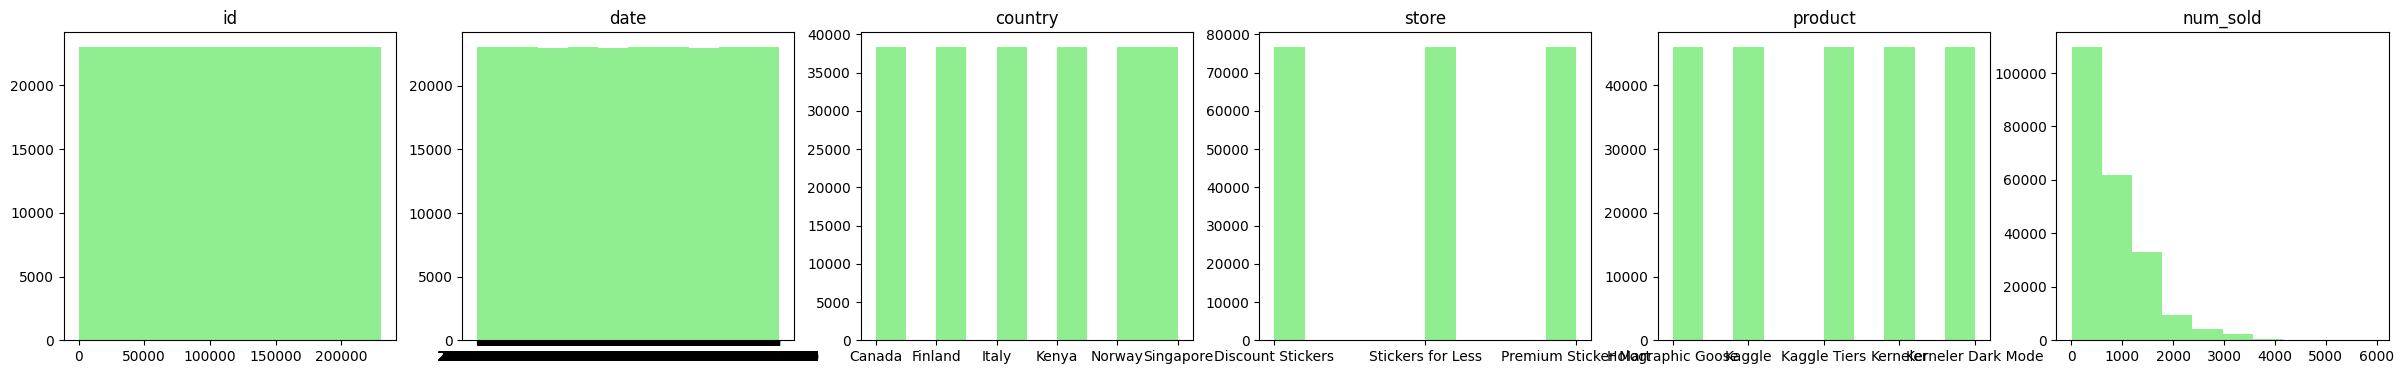

In [6]:
#Plotando histograma de cada coluna

fig, axes = plt.subplots(1, len(data_train.columns), figsize=(5 * len(data_train.columns), 4))

for ax, col in zip(axes, data_train.columns):
    ax.hist(data_train[col], color='lightgreen')
    ax.set_title(col)

In [43]:
data_processed = pre_processing(data_train)

In [45]:
#Criando variáveis X e y

X = data_processed.drop(columns=['num_sold'])
y = data_processed['num_sold']

In [46]:
#Quebrando em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Primeiro modelo de teste

In [61]:
#Criando modelos - catboost e random forest

random_forest = RandomForestRegressor()
catboost = CatBoostRegressor()

random_forest.fit(X_train,y_train)
catboost.fit(X_train,y_train, verbose=False)

forest_pred = random_forest.predict(X_test)
catboost_pred = catboost.predict(X_test)


In [62]:
#Avaliando modelos

print(f'MAE Random Forest: {mean_absolute_error(y_test, forest_pred)}')
print(f'MAE Catboost: {mean_absolute_error(y_test, catboost_pred)}')

print(f'MAPE Random Forest: {mean_absolute_percentage_error(y_test, forest_pred)}')
print(f'MAPE Catboost: {mean_absolute_percentage_error(y_test, catboost_pred)}')

MAE Random Forest: 63.19284484317093
MAE Catboost: 57.520627326951484
MAPE Random Forest: 0.08284737810621061
MAPE Catboost: 0.22617893775366477


In [ ]:
# Carregando dados para avaliação

data_val = pd.read_csv('/content/drive/MyDrive/Arquivos - Dados/Forecasting Sticker/test.csv')

In [ ]:
# Processando data

data_val_processed = pre_processing(data_val)

In [ ]:
#Predizendo resultados

data_val_processed['num_sold'] = catboost.predict(data_val_processed)

# Testando diversos modelos

In [69]:
# Criando função para testar modelos diferentes

def test_models(X_train, X_test, y_train, y_test, models):

  results = []

  for model in models:

    if isinstance(model, CatBoostRegressor):
      model_train = model
      model_train.fit(X_train, y_train, verbose=False)
      pred = model_train.predict(X_test)

      mape = mean_absolute_percentage_error(y_test, pred)
      print(f'MAPE {model.__class__.__name__}: {mape}')
      mae = mean_absolute_error(y_test, pred)
      print(f'MAE {model.__class__.__name__}: {mae}')
      print(f'\n')

      results.append({'model': model.__class__.__name__, 'MAPE': mape})
      #results.append({'model': model.__class__.__name__, 'MAE': mae})

    else:
      model_train = model
      model_train.fit(X_train, y_train)
      pred = model_train.predict(X_test)

      mape = mean_absolute_percentage_error(y_test, pred)
      print(f'MAPE {model.__class__.__name__}: {mape}')
      mae = mean_absolute_error(y_test, pred)
      print(f'MAE {model.__class__.__name__}: {mae}')
      print(f'\n')

      results.append({'model': model.__class__.__name__, 'MAPE': mape})
      #results.append({'model': model.__class__.__name__, 'MAE': mae})

  # Verificando e retornando o menor MAPE

  best_model = min(results, key=lambda x: x['MAPE'])
  print(f"Melhor modelo: {best_model['model']} com MAPE: {best_model['MAPE']}")
  #best_model = min(results, key=lambda x: x['MAE'])
  #print(f"\nMelhor modelo: {best_model['model']} com MAE: {best_model['MAE']}")

  return results

In [70]:
# Testando modelos

models = [LinearRegression(), DecisionTreeRegressor(), XGBRegressor(), RandomForestRegressor(), CatBoostRegressor(), LGBMRegressor(verbose=-1), AdaBoostRegressor(), GradientBoostingRegressor()]

results = test_models(X_train, X_test, y_train, y_test, models)

MAPE LinearRegression: 4.492047177008461
MAE LinearRegression: 224.37850155650392


MAPE DecisionTreeRegressor: 0.10371005612421177
MAE DecisionTreeRegressor: 79.55803127542258


MAPE XGBRegressor: 0.23212926669866887
MAE XGBRegressor: 58.10646764814792


MAPE RandomForestRegressor: 0.08271998990182705
MAE RandomForestRegressor: 63.10067929133146


MAPE CatBoostRegressor: 0.22617893775366477
MAE CatBoostRegressor: 57.520627326951484


MAPE LGBMRegressor: 0.16997690804094623
MAE LGBMRegressor: 62.56603078714514


MAPE AdaBoostRegressor: 4.553139067784751
MAE AdaBoostRegressor: 398.41504481498816


MAPE GradientBoostingRegressor: 0.7896202145829615
MAE GradientBoostingRegressor: 94.32221122514945



Melhor modelo: RandomForestRegressor com MAPE: 0.08271998990182705


#Melhorando hiperparametros

In [ ]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],   # Número de árvores
    'max_depth': [None, 5, 10, 20],  # Profundidade máxima da árvore
}

# Configuração do GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Executando a busca
grid_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")

# Avaliação no conjunto de teste
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE no conjunto de teste: {mape}")

In [72]:
#Testando o XGBoost

model_train = XGBRegressor(n_estimators=400,
                           max_depth=12,
                           learning_rate=0.1,
                           random_state=42
                           )

model_train.fit(X_train, y_train)
pred = model_train.predict(X_test)

mape = mean_absolute_percentage_error(y_test, pred)
print(f'MAPE {model_train.__class__.__name__}: {mape}')

#mae = mean_absolute_error(y_test, pred)
#print(f'MAE {model_train.__class__.__name__}: {mae}')

MAPE XGBRegressor: 0.13330103466282642


In [73]:
#Testando o Catboost

model_train = CatBoostRegressor(iterations=400,
                                learning_rate=0.1,
                                depth = 16,
                                verbose=False
                                )

model_train.fit(X_train, y_train)
pred = model_train.predict(X_test)

mape = mean_absolute_percentage_error(y_test, pred)
print(f'MAPE {model_train.__class__.__name__}: {mape}')

#mae = mean_absolute_error(y_test, pred)
#print(f'MAE {model_train.__class__.__name__}: {mae}')

MAPE CatBoostRegressor: 0.15585902923584857


In [78]:
#Testando o RandomForest

model_train = RandomForestRegressor(n_estimators=200,
                                    max_depth=30,
                                    random_state=42
                                    )

model_train.fit(X_train, y_train)
pred = model_train.predict(X_test)

mape = mean_absolute_percentage_error(y_test, pred)
print(f'MAPE {model_train.__class__.__name__}: {mape}')

MAPE RandomForestRegressor: 0.08268961540255469


#Teste com Redes Neurais

In [ ]:
#Teste com rede neural

network = MLPRegressor(hidden_layer_sizes=(100,100),
                       activation='relu',
                       alpha = 0.001,
                       verbose=True,
                       max_iter=100,
                       solver='lbfgs',
                       early_stopping=True,
                       validation_fraction=0.1)

network.fit(X_train, y_train)
pred = network.predict(X_test)

mape = mean_absolute_percentage_error(y_test, pred)
print(f'MAPE MLPRegressor: {mape}')

#Exportação para CSV

In [90]:
data_val = pd.read_csv('/content/drive/MyDrive/Arquivos - Dados/Forecasting Sticker/test.csv')

data_val['num_sold'] = 0

data_val_processed = pre_processing(data_val)

#Predizendo resultados

pred = network.predict(data_val_processed.drop(columns=['num_sold']))

In [91]:
submission = pd.DataFrame()

submission['id'] = data_val['id']
submission['num_sold'] = pred

In [92]:
submission.to_csv('submission.csv', index=False)